In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier

import os
from tqdm import tqdm

import rasterio
from rasterio.windows import Window
from pyproj import CRS

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


### Test con img de 40 bandas

In [2]:
tile = 'qwqw.tif'
samples = 'output.csv'

In [3]:
df = pd.read_csv(samples)
print(df.shape)

(360, 48)


In [4]:
bands = df.filter(like='band_').columns.to_list()
bands

['band_0',
 'band_1',
 'band_2',
 'band_3',
 'band_4',
 'band_5',
 'band_6',
 'band_7',
 'band_8',
 'band_9',
 'band_10',
 'band_11',
 'band_12',
 'band_13',
 'band_14',
 'band_15',
 'band_16',
 'band_17',
 'band_18',
 'band_19',
 'band_20',
 'band_21',
 'band_22',
 'band_23',
 'band_24',
 'band_25',
 'band_26',
 'band_27',
 'band_28',
 'band_29',
 'band_30',
 'band_31',
 'band_32',
 'band_33',
 'band_34',
 'band_35',
 'band_36',
 'band_37',
 'band_38',
 'band_39',
 'band_40',
 'band_41']

In [5]:
X = df[bands]
y = df['id']

clf = RandomForestClassifier(max_depth=5, random_state=0)
clf.fit(X, y)

RandomForestClassifier(max_depth=5, random_state=0)

In [6]:
def metadata_from_tile(in_raster):
    with rasterio.open(in_raster) as src:
        return(src.width, src.height, src.transform)

def sliding_windows(size, step_size, width, height, whole=False):
    """Slide a window of +size+ by moving it +step_size+ pixels"""
    w, h = size, size
    sw, sh = step_size, step_size
    end_i = height - h if whole else height
    end_j = width - w if whole else width
    for pos_i, i in enumerate(range(0, end_i, sh)):
        for pos_j, j in enumerate(range(0, end_j, sw)):
            real_w = w if whole else min(w, abs(width - j))
            real_h = h if whole else min(h, abs(height - i))
            yield Window(j, i, real_w, real_h), (pos_i, pos_j)

def create_windowed_dataset(in_raster, window, bands_list):
    img_df = pd.DataFrame()
    src = rasterio.open(in_raster)
    img = src.read(window=window)
    r,m,n = img.shape
    img_df = pd.DataFrame(img.reshape(r,m*n)).T
    img_df.columns = bands_list
    img_df = img_df.replace([np.inf, -np.inf], np.nan).fillna(-99)
    return(img_df)

In [7]:
width, height, transform = metadata_from_tile(tile)
windows = sliding_windows(100, 100, width, height)

In [8]:
window = list(windows)[14]

In [9]:
#leemos esa parte de la imagen y creamos las bandas según se crearon para el modelo original
src = rasterio.open(tile)
img = src.read(window=window[0]) 
r,m,n = img.shape
img_df = pd.DataFrame(img.reshape(r,m*n)).T.fillna(-99)
img_df.columns = bands
img_df

,band_0,band_1,band_2,band_3,band_4,band_5,band_6,band_7,band_8,band_9,...,band_32,band_33,band_34,band_35,band_36,band_37,band_38,band_39,band_40,band_41
0,0.0769,0.1001,0.1534,0.2188,0.2252,0.3128,0.2981,0.0918,0.1192,0.1694,...,0.53880,0.17700,0.07020,0.0284,0.0694,0.0308,0.5044,0.5007,0.1932,0.0828
1,0.0773,0.1018,0.1504,0.2142,0.2268,0.3124,0.2963,0.0918,0.1200,0.1708,...,0.52445,0.18110,0.07570,0.0309,0.0708,0.0317,0.4828,0.4766,0.1953,0.0837
2,0.0820,0.1058,0.1554,0.2250,0.2307,0.3180,0.3005,0.0913,0.1242,0.1738,...,0.54295,0.17805,0.07015,0.0288,0.0722,0.0313,0.4980,0.4886,0.1921,0.0799
3,0.0798,0.1086,0.1640,0.2292,0.2345,0.3203,0.2984,0.0933,0.1248,0.1786,...,0.52480,0.18085,0.07525,0.0285,0.0600,0.0292,0.4928,0.4831,0.1910,0.0809
4,0.0828,0.1038,0.1550,0.2218,0.2308,0.3197,0.3059,0.0916,0.1248,0.1776,...,0.51875,0.18055,0.07515,0.0293,0.0705,0.0327,0.4652,0.4748,0.1907,0.0827
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.0645,0.0932,0.0986,0.2640,0.2706,0.3185,0.2289,0.0782,0.1068,0.1216,...,0.27305,0.24815,0.15580,0.0451,0.0637,0.0710,0.2048,0.2214,0.2647,0.1787
9996,0.0651,0.0950,0.0998,0.2664,0.2656,0.3115,0.2226,0.0773,0.1050,0.1218,...,0.26220,0.24220,0.15405,0.0421,0.0637,0.0702,0.1968,0.2026,0.2571,0.1735
9997,0.0692,0.0982,0.1030,0.2670,0.2701,0.3138,0.2249,0.0797,0.1110,0.1208,...,0.25980,0.24015,0.15230,0.0430,0.0674,0.0727,0.2010,0.2107,0.2541,0.1727
9998,0.0674,0.0973,0.1042,0.2730,0.2752,0.3169,0.2282,0.0771,0.1084,0.1228,...,0.25715,0.23935,0.15370,0.0396,0.0612,0.0675,0.1896,0.2015,0.2537,0.1745


In [10]:
res = clf.predict(img_df).astype(np.float64)
res = np.expand_dims(res.reshape(n,m), axis=0)
res

array([[[1., 1., 1., ..., 2., 1., 3.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 2., 1., 1.],
        ...,
        [1., 1., 1., ..., 3., 3., 3.],
        [1., 1., 1., ..., 3., 3., 3.],
        [1., 1., 1., ..., 3., 3., 3.]]])

In [11]:
width, height, transform = metadata_from_tile(tile)
#agrandar si tienen mas memoria, corre un poco mas rapido pero ojo que se pueden distorsionar los bordes
windows = sliding_windows(100, 100, width, height)
os.makedirs('./predictions/', exist_ok=True)
out_raster = f'./predictions/{tile}'
with rasterio.open(out_raster, 'w', driver='GTiff', count=1, width=width, height=height, dtype=np.float64, transform=transform, crs=CRS.from_epsg(4326), compress='lzw'
) as dst:
    for window, _ in tqdm(windows):           
        img_df = create_windowed_dataset(tile, window, bands)
        n_bands = img_df.shape[1]
        r,m,n = (n_bands, window.width, window.height)
        #clf es el clasificador que entrenamos antes
        res = clf.predict(img_df).astype(np.float64)
        res = np.expand_dims(res.reshape(m,n), axis=0)
        dst.write(res, window=window)

221it [00:29,  7.61it/s]


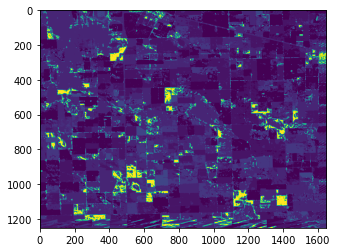

In [12]:
from matplotlib import pyplot
src = rasterio.open(out_raster)
pyplot.imshow(src.read(1))
pyplot.show()